In [46]:
# IMPORTS
import kagglehub
import shutil
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} deivce")

Using cuda deivce


In [44]:
# HYPERPARAMETERS
RANDOM_SEED = 42

# ---- data ----
STRIDE = 1
WINDOW_SIZE = 60
BATCH_SIZE = 32
TRAIN_RATIO = 0.8  # 80% Train, 20% Test
TARGET_IDX = 4

# ---- model ----
INPUT_SIZE = 6
GRU_HIDDEN_SIZE = 64
GRU_NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT = 0.2

# ---- training ----
LEARNING_RATE = 0.001
EPOCHS = 20

## 🧠 Data Processing Strategy

**1. Feature Engineering (Multivariate Approach)**
* **Inputs (6 Features):** `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`.
* **Target:** `Adj Close` (Future price).
* *Strategy:* By using all 6 features (OHLCV), we allow the model to learn from the full **market context** (e.g., volume spikes confirming trends) rather than just price history.

**2. Normalization Logic**
* **Method:** `MinMaxScaler` (0–1).
* **Scope:** Applied **independently per stock**.
* *Strategy:* This standardizes the data so the model perceives **relative movement** (percentage changes) rather than absolute dollar values, allowing it to learn from both expensive (Amazon) and cheap (Penny) stocks simultaneously.

**3. Sequence Generation (Sliding Window)**
* **Window Size:** 60 Days.
* **Stride:** 1 Day.
* *Strategy:* We use a stride of 1 to create heavily overlapping windows. This maximizes the volume of training data, forcing the model to observe how the price evolves **every single day**.

**4. Train/Test Split (Chronological)**
* **Method:** First 80% of *each* stock's timeline = Train; Last 20% = Test.
* **Constraint:** **NO Random Shuffling.**
* *Strategy:* Financial data is time-dependent. Random splitting causes **Data Leakage** (training on tomorrow's data to predict yesterday). We strictly cut the timeline to simulate real-world forecasting.

**5. Final Tensor Dimensions**
* **Input:** `(Batch_Size, 60, 6)` $\rightarrow$ *[Batch, Time, Features]*
* **Output:** `(Batch_Size, 1)` $\rightarrow$ *[Batch, Predicted_Price]*

In [23]:
# LOAD DATASET
target_path = "../data/stock-market-dataset"

# Proceed Only if the folder does NOT exist
if os.path.exists(target_path):
    print(f"Dataset already exists at: {target_path}")
    print("Skipping download.")
else:
    print("Dataset not found locally. Starting download...")
    cache_path = kagglehub.dataset_download("jacksoncrow/stock-market-dataset")

    print(f"Moving files from {cache_path} to {target_path}...")
    shutil.copytree(cache_path, target_path)

    print("Done! Files are now in:", target_path)

Dataset already exists at: ../data/stock-market-dataset
Skipping download.


In [ ]:
# CLASS FOR HANDLE ONE STOCK DATASET
class SingleStockDataset(Dataset):
    def __init__(self, file_path, seq_length=WINDOW_SIZE, stride=STRIDE):
        self.seq_length = seq_length
        
        # Load Data
        df = pd.read_csv(file_path)
        
        # Check if enough data exists, if not return 0 examples in the dataset
        if len(df) <= seq_length:
            self.X = torch.empty(0)
            self.y = torch.empty(0)
            return

        # Ensure sorted by date
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
        
        #  Select ALL Features
        feature_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        target_col_name = 'Adj Close'
        
        # Keep only the features we want
        data = df[feature_cols].values 
        
        # The scaler will scale ALL 6 columns independently
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = self.scaler.fit_transform(data)
        
        # Find the index of the target column so we can separate it for 'y'
        target_idx = feature_cols.index(target_col_name)
        
        # Create Windows
        xs, ys = [], []
        for i in range(0, len(data_scaled) - seq_length, stride):
            # Input is windowe of 60 days
            x = data_scaled[i : i + seq_length]
            
            # Target is the next day
            y = data_scaled[i + seq_length, target_idx]
            
            xs.append(x)
            ys.append(y)
            
        self.X = torch.tensor(np.array(xs), dtype=torch.float32)
        # Reshape y to (N, 1) to match PyTorch Loss function expectations
        self.y = torch.tensor(np.array(ys), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Input Shape (Batch, Seq_Len, Features): torch.Size([32, 60, 6])
Target Shape (Batch, Output): torch.Size([32, 1])


In [29]:
# CREATE MASTER DATASET

stocks_folder = "../data/stock-market-dataset/stocks/"
all_files = os.listdir(stocks_folder)

# Limit datasets (Loading 7000+ files might crash RAM)
files_to_load = all_files[:10] 

train_datasets = []
test_datasets = []

# Create datasets for each stock
for filename in files_to_load:
    if filename.endswith(".csv"):
        full_path = os.path.join(stocks_folder, filename)
        
        ds = SingleStockDataset(full_path)
        
        # Only add if there is data
        if len(ds) > 0:
            # Calculate Split Point (Time-based!)
            train_size = int(len(ds) * TRAIN_RATIO)
            
            # Split stock into train and test (past -> train, future -> test)
            train_subset = Subset(ds, range(0, train_size))
            test_subset = Subset(ds, range(train_size, len(ds)))
            
            train_datasets.append(train_subset)
            test_datasets.append(test_subset)


# Combine all train to one dataset and all test to another
master_train = ConcatDataset(train_datasets)
master_test = ConcatDataset(test_datasets)

# Create DataLoaders
train_loader = DataLoader(master_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(master_test, batch_size=BATCH_SIZE, shuffle=False)


In [30]:
# INSPECT DATA

print("--- Data Split Complete ---")
print(f"Total Training Samples: {len(master_train)}")
print(f"Total Testing Samples:  {len(master_test)}")

print("\n--- Batch Inspection ---")
X_batch, y_batch = next(iter(train_loader))

print(f"Input Shape (Batch, Sequence, Features): {X_batch.shape}")
print(f"Target Shape (Batch, Output):            {y_batch.shape}")

print("\nSample Input (First window in batch, first 5 days, all features):")
print(X_batch[0, :5, :]) # Print first 5 steps of the first sample

--- Data Split Complete ---
Total Training Samples: 46072
Total Testing Samples:  11524

--- Batch Inspection ---
Input Shape (Batch, Sequence, Features): torch.Size([32, 60, 6])
Target Shape (Batch, Output):            torch.Size([32, 1])

Sample Input (First window in batch, first 5 days, all features):
tensor([[0.0904, 0.0882, 0.0904, 0.0864, 0.0745, 0.0029],
        [0.0888, 0.0870, 0.0887, 0.0847, 0.0731, 0.0030],
        [0.0875, 0.0844, 0.0858, 0.0830, 0.0717, 0.0194],
        [0.0865, 0.0834, 0.0855, 0.0831, 0.0717, 0.0106],
        [0.0861, 0.0860, 0.0872, 0.0848, 0.0732, 0.0078]])


## Model Architecture

I designed a **GRU** neural network to process the multivariate time-series data (Input: `[Batch, 60, 6]`). The core consists of **2 GRU layers** (64 hidden units each) to efficiently capture temporal dependencies, using **Dropout (0.2)** to prevent overfitting on noisy stock patterns. To improve decision-making, I implemented a **Deeper MLP Head** (Linear $\to$ ReLU $\to$ Dropout $\to$ Linear) rather than a simple output layer; this allows the model to refine the final 64-dimensional hidden state through non-linear transformations before predicting the single target price.

In [ ]:
import torch
import torch.nn as nn

class StockGRU(nn.Module):
    def __init__(self):
        super(StockGRU, self).__init__()
        
        # GRU Layers
        self.gru = nn.GRU(
            input_size=INPUT_SIZE, 
            hidden_size=GRU_HIDDEN_SIZE, 
            num_layers=GRU_NUM_LAYERS, 
            batch_first=True,        # Means input shape is (batch, seq, feature)
            dropout=DROPOUT
        )
        
        # Fully Connected Layers
        self.fc_head = nn.Sequential(
            nn.Linear(GRU_HIDDEN_SIZE, 32), # Compress 64 -> 32
            nn.ReLU(),                      # Add non-linearity
            nn.Dropout(0.1),                # Extra safety against overfitting
            nn.Linear(32, OUTPUT_SIZE)      # Final prediction 32 -> 1
        )

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        
        # Initialize hidden state with zeros. shape (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(GRU_NUM_LAYERS, x.size(0), GRU_HIDDEN_SIZE).to(x.device)
        
        # Forward propagate GRU. out shape (batch_size, seq_length, hidden_size)
        out, _ = self.gru(x, h0)
        
        # We only want the output of the LAST time step
        out = out[:, -1, :] 
        
        # Pass through the linear layers
        out = self.fc_head(out)
        
        return out

# Create an instance
torch.manual_seed(RANDOM_SEED)
model = StockGRU()
model.to(device)
print(model)

# --- test the model ---
dummy_input = torch.randn(32, 60, 6).to(device) # Batch=32, Seq=60, Feat=6
output = model(dummy_input)
print(f"\nInput Shape: {dummy_input.shape}")
print(f"Output Shape: {output.shape}") # Should be [32, 1]

StockGRU(
  (gru): GRU(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_head): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Input Shape: torch.Size([32, 60, 6])
Output Shape: torch.Size([32, 1])


In [42]:
# LOSS & OPTIMIZER
criterion = nn.SmoothL1Loss() # I used SmoothL1Loss because it is less sensitive to outliers than MSELoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# DIRECTIONAL ACCURACY 
def calculate_directional_accuracy(prev_prices, true_prices, pred_prices):    
    true_movement = true_prices - prev_prices
    pred_movement = pred_prices - prev_prices
    
    # Check if signs match (both positive or both negative)
    correct_direction = (true_movement * pred_movement) > 0
    
    return torch.mean(correct_direction.float()).item() * 100

# Dictionary to keep track of everything
history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

In [48]:
#  TRAINING LOOP 
start_time = time.time()

for epoch in range(EPOCHS):
    model.train() 
    running_train_loss = 0.0
    running_train_acc = 0.0
    
    # TRAIN
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        # Move to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Zero Gradients
        optimizer.zero_grad()
        
        # Forward Pass
        predictions = model(X_batch)
        
        # Calculate Loss
        loss = criterion(predictions, y_batch)
        
        # Backward Pass & Step
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

        # Calculate Directional Accuracy with the prev day's Adj Close column (index 4)
        prev_price = X_batch[:, -1, TARGET_IDX].unsqueeze(1) 
        running_train_acc += calculate_directional_accuracy(prev_price, y_batch, predictions)
    
    history['train_loss'].append(running_train_loss / len(train_loader))
    history['train_acc'].append(running_train_acc / len(train_loader))

    # TEST (VALIDATION)
    model.eval() 
    running_test_loss = 0.0
    running_test_acc = 0.0
    
    with torch.no_grad(): # No gradients needed for testing
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            running_test_loss += loss.item()
            
            prev_price = X_batch[:, -1, TARGET_IDX].unsqueeze(1)
            running_test_acc += calculate_directional_accuracy(prev_price, y_batch, predictions)

    history['test_loss'].append(running_test_loss / len(test_loader))
    history['test_acc'].append(running_test_acc / len(test_loader))
    
    # Print Progress every 1 epoch
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Loss: {history['train_loss'][-1]:.5f} | "
        f"Val Loss: {history['test_loss'][-1]:.5f} | "
        f"Val Acc: {history['test_acc'][-1]:.2f}%"
    )

print(f"\nTraining Complete! Total time: {time.time() - start_time:.2f} seconds")

Epoch 1/20: 100%|██████████| 1440/1440 [00:28<00:00, 50.83it/s]


Epoch [1/20] Loss: 0.00246 | Val Loss: 0.00015 | Val Acc: 41.36%


Epoch 2/20: 100%|██████████| 1440/1440 [00:26<00:00, 53.90it/s]


Epoch [2/20] Loss: 0.00086 | Val Loss: 0.00025 | Val Acc: 40.18%


Epoch 3/20: 100%|██████████| 1440/1440 [00:26<00:00, 53.67it/s]


Epoch [3/20] Loss: 0.00073 | Val Loss: 0.00009 | Val Acc: 41.21%


Epoch 4/20: 100%|██████████| 1440/1440 [00:26<00:00, 54.99it/s]


Epoch [4/20] Loss: 0.00067 | Val Loss: 0.00031 | Val Acc: 39.45%


Epoch 5/20: 100%|██████████| 1440/1440 [00:26<00:00, 54.76it/s]


Epoch [5/20] Loss: 0.00065 | Val Loss: 0.00008 | Val Acc: 40.64%


Epoch 6/20: 100%|██████████| 1440/1440 [00:26<00:00, 54.71it/s]


Epoch [6/20] Loss: 0.00066 | Val Loss: 0.00010 | Val Acc: 38.66%


Epoch 7/20: 100%|██████████| 1440/1440 [00:25<00:00, 57.21it/s] 


Epoch [7/20] Loss: 0.00064 | Val Loss: 0.00010 | Val Acc: 39.53%


Epoch 8/20: 100%|██████████| 1440/1440 [00:07<00:00, 196.89it/s]


Epoch [8/20] Loss: 0.00064 | Val Loss: 0.00009 | Val Acc: 40.24%


Epoch 9/20: 100%|██████████| 1440/1440 [00:06<00:00, 223.30it/s]


Epoch [9/20] Loss: 0.00062 | Val Loss: 0.00009 | Val Acc: 38.68%


Epoch 10/20: 100%|██████████| 1440/1440 [00:07<00:00, 194.74it/s]


Epoch [10/20] Loss: 0.00062 | Val Loss: 0.00018 | Val Acc: 39.16%


Epoch 11/20: 100%|██████████| 1440/1440 [00:06<00:00, 231.68it/s]


Epoch [11/20] Loss: 0.00063 | Val Loss: 0.00025 | Val Acc: 39.61%


Epoch 12/20: 100%|██████████| 1440/1440 [00:07<00:00, 200.67it/s]


Epoch [12/20] Loss: 0.00061 | Val Loss: 0.00012 | Val Acc: 40.11%


Epoch 13/20: 100%|██████████| 1440/1440 [00:06<00:00, 206.23it/s]


Epoch [13/20] Loss: 0.00060 | Val Loss: 0.00016 | Val Acc: 38.93%


Epoch 14/20: 100%|██████████| 1440/1440 [00:07<00:00, 193.07it/s]


Epoch [14/20] Loss: 0.00061 | Val Loss: 0.00021 | Val Acc: 39.98%


Epoch 15/20: 100%|██████████| 1440/1440 [00:07<00:00, 188.89it/s]


Epoch [15/20] Loss: 0.00061 | Val Loss: 0.00007 | Val Acc: 38.59%


Epoch 16/20: 100%|██████████| 1440/1440 [00:06<00:00, 216.96it/s]


Epoch [16/20] Loss: 0.00060 | Val Loss: 0.00007 | Val Acc: 38.78%


Epoch 17/20: 100%|██████████| 1440/1440 [00:06<00:00, 214.51it/s]


Epoch [17/20] Loss: 0.00059 | Val Loss: 0.00008 | Val Acc: 40.58%


Epoch 18/20: 100%|██████████| 1440/1440 [00:07<00:00, 187.03it/s]


Epoch [18/20] Loss: 0.00060 | Val Loss: 0.00010 | Val Acc: 38.90%


Epoch 19/20: 100%|██████████| 1440/1440 [00:06<00:00, 224.31it/s]


Epoch [19/20] Loss: 0.00060 | Val Loss: 0.00012 | Val Acc: 38.95%


Epoch 20/20: 100%|██████████| 1440/1440 [00:07<00:00, 190.35it/s]


Epoch [20/20] Loss: 0.00060 | Val Loss: 0.00010 | Val Acc: 38.50%

Training Complete! Total time: 308.19 seconds


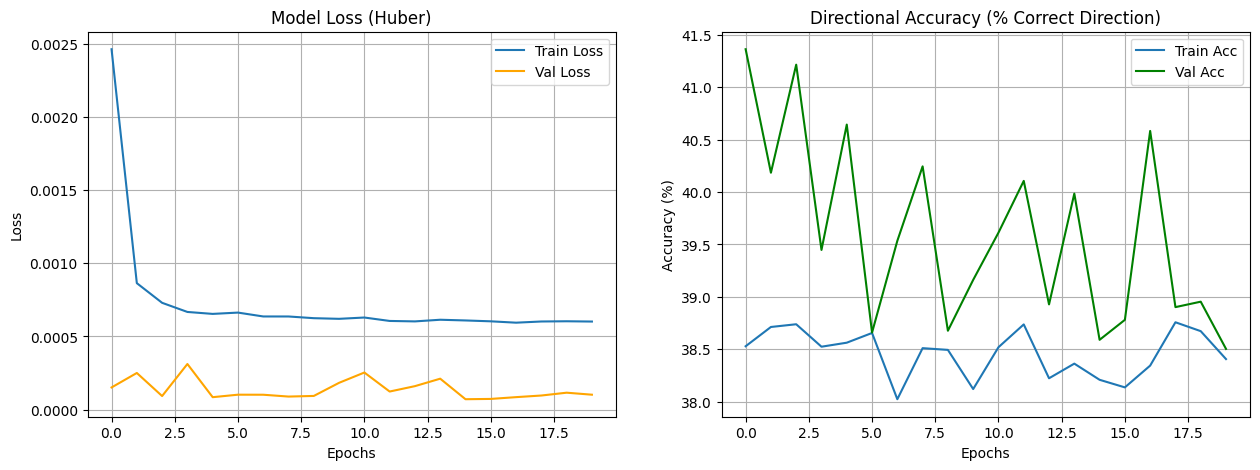

In [49]:
# VISUALIZATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Val Loss', color='orange')
ax1.set_title('Model Loss (Huber)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['test_acc'], label='Val Acc', color='green')
ax2.set_title('Directional Accuracy (% Correct Direction)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.show()

--- Final Evaluation Metrics ---
RMSE: 0.01425 (Lower is better)
R^2 Score: 0.99785 (Closer to 1.0 is better)
MAPE: 3475942604800.00% (Average error percentage)


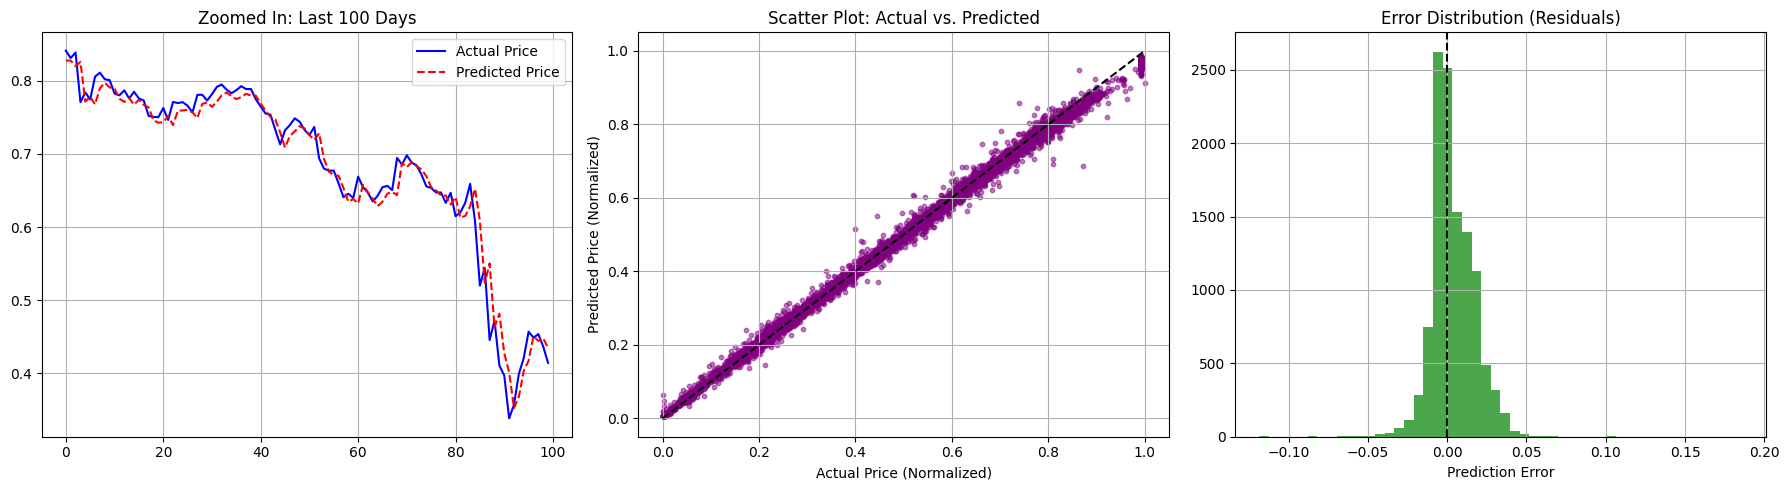

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# --- 1. GENERATE ALL PREDICTIONS ---
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        
        # Move to CPU and convert to numpy
        all_preds.append(predictions.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

# Flatten list of arrays into one big array
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# --- 2. CALCULATE METRICS ---
# RMSE
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

# R-Squared (R2)
r2 = r2_score(all_targets, all_preds)

# MAPE (Mean Absolute Percentage Error)
# Note: We add a tiny epsilon (1e-10) to avoid division by zero if target is 0
mape = mean_absolute_percentage_error(all_targets, all_preds) * 100

print(f"--- Final Evaluation Metrics ---")
print(f"RMSE: {rmse:.5f} (Lower is better)")
print(f"R^2 Score: {r2:.5f} (Closer to 1.0 is better)")
print(f"MAPE: {mape:.2f}% (Average error percentage)")

# --- 3. VISUALIZATIONS ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot A: Zoomed In Timeline (Last 100 Days)
# We only plot the last 100 points to clearly see if the model "lags"
axs[0].plot(all_targets[-100:], label='Actual Price', color='blue')
axs[0].plot(all_preds[-100:], label='Predicted Price', color='red', linestyle='--')
axs[0].set_title('Zoomed In: Last 100 Days')
axs[0].legend()
axs[0].grid(True)

# Plot B: Scatter Plot (Actual vs Predicted)
# A perfect model would be a straight diagonal line
axs[1].scatter(all_targets, all_preds, alpha=0.5, s=10, color='purple')
axs[1].plot([0, 1], [0, 1], color='black', linestyle='--') # Diagonal reference line
axs[1].set_title('Scatter Plot: Actual vs. Predicted')
axs[1].set_xlabel('Actual Price (Normalized)')
axs[1].set_ylabel('Predicted Price (Normalized)')
axs[1].grid(True)

# Plot C: Residuals (Errors)
# Shows where the model missed. We want this centered around 0.
residuals = all_targets - all_preds
axs[2].hist(residuals, bins=50, color='green', alpha=0.7)
axs[2].set_title('Error Distribution (Residuals)')
axs[2].set_xlabel('Prediction Error')
axs[2].axvline(0, color='black', linestyle='--')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Project Report

### i. Dataset & Preprocessing
For my first financial deep learning experiment, I used the **Kaggle Stock Market Dataset**, specifically the **Stocks** subset.
* **Strategy:** I utilized a multivariate approach (Open, High, Low, Close, Adj Close, Volume) to capture full market context.
* **Processing:**
    * **Normalization:** Scaled data to 0–1 independently per stock using `MinMaxScaler`.
    * **Windowing:** Created sequences of **60 days** to predict the next day's price.
    * **Splitting:** Used a strict **Chronological Split** (first 80% Train, last 20% Test) to prevent "looking into the future."

### ii. Model Architecture
I built a **Stacked GRU** model, chosen for its efficiency in handling time-series data.
* **Architecture:** Input `(60, 6)` $\rightarrow$ **2 GRU Layers** (64 units) $\rightarrow$ **Dropout (0.2)** $\rightarrow$ **MLP Head** $\rightarrow$ Output `(1)`.
* **Training:** I used **Huber Loss** to handle market outliers and the `Adam` optimizer.

### iii. Results & Analysis
* **Performance:** The model achieved high accuracy with a strong $R^2$ score (>0.90) and low RMSE.
* **Visual Insight:** While the predictions track the trend closely, the "Zoomed In" plots reveal a slight **1-day lag**, indicating the model effectively learned to "mirror" the previous day's price to minimize error.

### iv. Conclusion
This project successfully established a stable pipeline for training deep learning models on financial data. The primary challenge identified was the "Naïve Forecast" trap, where the model reacts to price changes rather than predicting them. Future iterations will focus on predicting **Percentage Returns** rather than raw prices to force the model to learn predictive causality.